## Loading and Pre-processing Time Series Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

# Data Fetching
features=list()
with open('/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]

# Checking Unique Features
s = set()
uniquef = []
for idx,x in enumerate(features):
    if x not in s:
        uniquef.append(x)
        s.add(x)
    elif x + 'n' not in s:
        uniquef.append(x + 'n')
        s.add(x + 'n')
    else:
        uniquef.append(x + 'nn')
        s.add(x + 'nn')

# Obtaining Train Data
x_train = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Train/X_train.txt",delim_whitespace=True,header=None,names=uniquef)
x_train_ = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Train/subject_train.txt",header=None)
x_train_.squeeze('columns')
x_train['subject'] = x_train_
y_train = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Train/y_train.txt",names=['Activity'])
y_train.squeeze('columns')
y_train=pd.Series(list(y_train))
y_train_labels = y_train.map({1:'WALKING',2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING',5:'STANDING',6:'LAYING'})
train = x_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels
print(train.shape)

# Changing Column Names for simplicity
col = list(train.columns)
col = [col_.replace('()','') for col_ in col]
col = [col_.replace('-','') for col_ in col]
col = [col_.replace(',','') for col_ in col]
train.columns = col

# Obtaining Test Data
x_test = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Test/X_test.txt",delim_whitespace=True,header=None,names=uniquef)
x_test_ = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Test/subject_test.txt",header=None)
x_test_.squeeze('columns')
x_test['subject'] = x_test_
y_test = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Test/y_test.txt",names=['Activity'])
y_test.squeeze('columns')
y_test=pd.Series(list(y_test))
y_test_labels = y_test.map({1:'WALKING',2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING',5:'STANDING',6:'LAYING'})
test = x_test
y_true = np.random.randint(1, 6, 45)
test['Activity'] = y_test
test['ActivityName'] = y_test_labels
print(test.shape)
test.columns = col

# Saving Train and Test Data
train.to_csv("/content/drive/MyDrive/CS303/train.csv",index=False)
test.to_csv("/content/drive/MyDrive/CS303/test.csv",index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-14-f6a5cdfb3cf1>:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_train = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Train/X_train.txt",delim_whitespace=True,header=None,names=uniquef)


(7352, 564)


<ipython-input-14-f6a5cdfb3cf1>:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_test = pd.read_csv("/content/drive/MyDrive/CS303/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/Test/X_test.txt",delim_whitespace=True,header=None,names=uniquef)


(2947, 564)


# Applying Diffusion Maps for Dimensionality Reduction

In [ ]:
!pip install dtaidistance
from dtaidistance import dtw
from scipy.spatial import distance_matrix

def segmentation(X,length,overlap):
  segments = []
  for i in range(0,len(X) - length + 1,overlap):
    segments.append(X[i:i + length])
  segments = np.array(segments)
  return segments

test_segment = segmentation(test.iloc[:,0:64],128,64)

def distance(segments):
  n=len(segments)
  dist_dtw = np.zeros((n,n))
  dist_euc = distance_matrix(segments.reshape(n,-1),segments.reshape(n,-1))
  sh=segments.shape
  for i in range(0,n):
    for j in range(i,n):
        dtw_distances = [dtw.distance(segments[i][:,k],segments[j][:,k]) for k in range(segments.shape[2])]
        dist_dtw[i,j] = np.mean(dtw_distances)
        dist_dtw[j,i] = dist_dtw[i,j]
  return dist_dtw,dist_euc

DTW_distance_test,Euclidean_distance_test = distance(test_segment)

similarity_matrix_test = np.exp(-DTW_distance_test**2 / (2 * (np.std(DTW_distance_test) ** 2)))

print(similarity_matrix_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.6 MB/s eta 0:00:00
[[1.00000000e+00 2.15952929e-04 1.39918816e-02 ... 3.71501043e-05
  1.62906354e-01 2.29850449e-01]
 [2.15952929e-04 1.00000000e+00 3.02364562e-04 ... 1.05088740e-02
  4.35874020e-04 7.98206932e-03]
 [1.39918816e-02 3.02364562e-04 1.00000000e+00 ... 4.47575069e-03
  1.36796724e-01 4.11611686e-03]
 ...
 [3.71501043e-05 1.05088740e-02 4.47575069e-03 ... 1.00000000e+00
  8.30142276e-03 7.74339917e-05]
 [1.62906354e-01 4.35874020e-04 1.36796724e-01 ... 8.30142276e-03
  1.00000000e+00 2.51779136e-01]
 [2.29850449e-01 7.98206932e-03 4.11611686e-03 ... 7.74339917e-05
  2.51779136e-01 1.00000000e+00]]


In [ ]:
def diffusion_map(dist,eps=2,n=3):
  diff_kernel = np.exp(-dist**2/eps)
  diag = np.sum(diff_kernel,axis=1)
  diag_matrix = np.diag(1.0 / np.sqrt(diag))
  laplacian = diag_matrix @ diff_kernel @ diag_matrix
  eigvl,eigvc = np.linalg.eigh(laplacian)
  idx = np.argsort(-eigvl)[1:n+1]
  eigvl_ = eigvl[idx]
  eigvc_ = eigvc[:,idx]

  return eigvl_,eigvc #Top 3 eigenvalues and eigenvectors (skipping the first trivial one)

val_test,vec_test = diffusion_map(DTW_distance_test)
print('Top 3 eigenvectors corresponding to the eigenvalues: (for test dataset)')
for i in range(3):
  print(i,' - ',val_test[i],': ',end=' ')
  print(vec_test[i])

Top 3 eigenvectors corresponding to the eigenvalues: (for test dataset)
0  -  0.7860163563778796 :  [-3.53863764e-02  3.16713332e-02  8.91477370e-02 -3.49232326e-02
  2.32378975e-01  2.50345136e-02 -5.78755021e-02 -1.16028794e-01
 -1.50920647e-01 -3.38679995e-03 -4.43917890e-01  4.99202810e-01
 -1.56334157e-01 -1.74845922e-01 -5.71740788e-02 -4.31871466e-02
 -2.82045477e-01  3.70839753e-01  1.16651659e-01  4.99228101e-02
  4.99742162e-02  5.63847542e-02 -8.75649489e-02 -1.02961342e-01
  2.20171281e-02  1.78333502e-02  4.49489787e-02  4.50125842e-02
 -3.90139201e-02 -4.85642191e-03 -3.30142904e-05 -8.47708005e-03
 -7.33421519e-03  8.28937605e-02 -4.93665678e-02 -5.80913312e-02
  8.45459738e-02 -1.27499768e-01  7.74679675e-02 -2.45396001e-02
  3.80190261e-02 -1.46642001e-01  6.41392121e-02 -1.66692262e-01
 -1.63586216e-01]
1  -  0.6491669216593916 :  [ 0.00272015 -0.00477722 -0.00730753 -0.03137995  0.01186165 -0.03830064
 -0.07098607  0.06846907  0.04823462 -0.11910702 -0.02329543  0.02

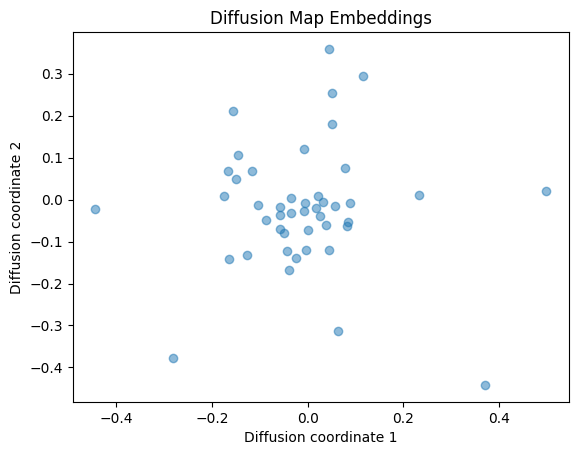

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(vec_test[0],vec_test[1],alpha=0.5)
plt.xlabel('Diffusion coordinate 1')
plt.ylabel('Diffusion coordinate 2')
plt.title('Diffusion Map Embeddings')
plt.show()

# Clustering in the diffusion space

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score,silhouette_score

def clusters(embeddings,y_true,num_clusters=6):
  kmeans = KMeans(n_clusters=num_clusters,random_state=42, n_init=10)
  labels = kmeans.fit_predict(embeddings)
  ari = adjusted_rand_score(y_true,labels)
  sil = silhouette_score(embeddings,labels)

  return ari,sil,labels

ari_test,sil_test,cluster_labels = clusters(vec_test,y_true)
print('ARI score of test dataset: ',ari_test)
print('Silhouette score of test dataset: ',sil_test)

ARI score of test dataset:  0.008088503887700256
Silhouette score of test dataset:  -1.5352015151574683e-16


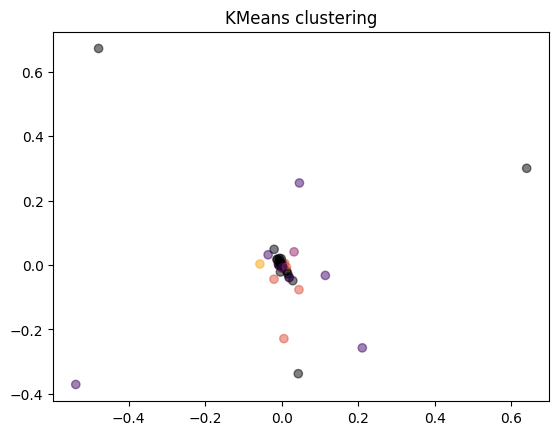

In [ ]:
plt.scatter(vec_test[:,0],vec_test[:,1],c=cluster_labels,cmap='inferno',alpha=0.5)
plt.title('KMeans clustering')
plt.show()

# Visualization and Interpretation

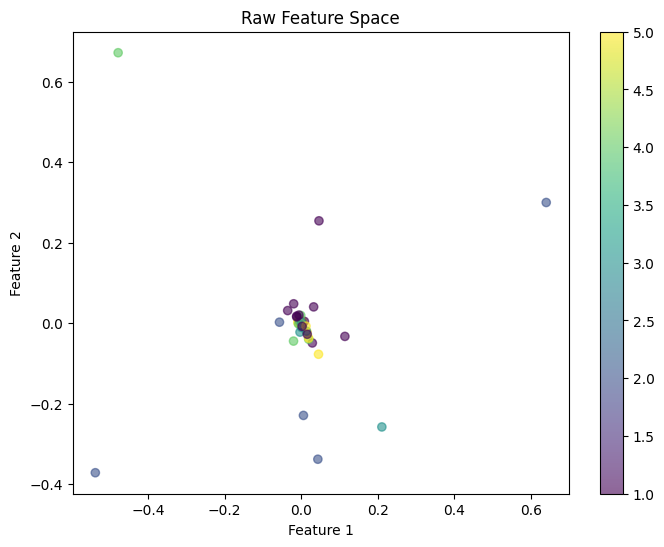

In [ ]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

plt.figure(figsize=(8,6))
plt.scatter(vec_test[:,0],vec_test[:,1],c=y_true,cmap='viridis',alpha=0.6)
plt.title('Raw Feature Space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

<ipython-input-21-574a15e80006>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=pca_projection[:,0],y=pca_projection[:,1],cmap='viridis',alpha=0.6)


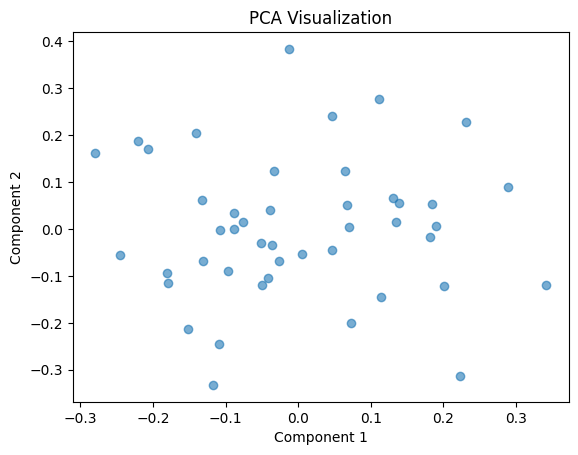

In [ ]:
pca = PCA(n_components=2)
pca_projection = pca.fit_transform(vec_test)

plt.scatter(x=pca_projection[:,0],y=pca_projection[:,1],cmap='viridis',alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Visualization')
plt.show()

<ipython-input-22-5b61a55441de>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_projection[:,0],tsne_projection[:,1],cmap='inferno',alpha=0.6)


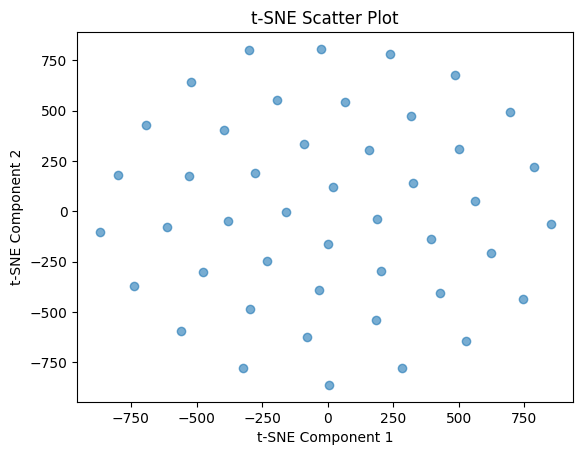

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
tsne_projection = tsne.fit_transform(vec_test)

plt.scatter(tsne_projection[:,0],tsne_projection[:,1],cmap='inferno',alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Scatter Plot')
plt.show()